# Building of French ACC/UAC control sectors tables

#### Air traffic control sectors data can be found on the [SIA website](https://www.sia.aviation-civile.gouv.fr) in the eAIP section (ENR 3.8)

In [1]:
url = "https://www.sia.aviation-civile.gouv.fr/dvd/eAIP_16_AUG_2018/FRANCE/AIRAC-2018-08-16/html/eAIP/FR-ENR-3.8-fr-FR.html#ENR-3.8"

In [2]:
import requests
from bs4 import BeautifulSoup
soup = BeautifulSoup(requests.get(url).content, "lxml")
list_tables = soup.find_all('table')

##### Get the coordinates of airspace volumes (sixth table)

In [3]:
import geopandas as gpd
from shapely.geometry import Point, Polygon, MultiPolygon
from shapely.ops import nearest_points
from shapely.geometry import MultiPoint

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
france = world[world.name == "France"].copy()
france.geometry = france.geometry.intersection(Polygon([(-10,41),(-10,52),(10,52),(10,41)]))
poly = france.geometry.iloc[0][1]
mp = MultiPoint(poly.exterior.coords)
fr = list(mp.geoms)

def get_points_between(before_point, after_point):
    b_n = nearest_points(mp, before_point)[0]
    a_n = nearest_points(mp, after_point)[0]
    tlist = [point for point in fr 
             if min(fr.index(b_n), fr.index(a_n)) <= fr.index(point) <= max(fr.index(b_n), fr.index(a_n))]
    clist = [point for point in fr if point not in tlist]
    tlist = clist if len(tlist) > len(clist) else tlist
    return tlist if fr.index(b_n) <= fr.index(a_n) else tlist[::-1]

def lat_conv(slat):
    val = round(float(slat[0:2]) + float(slat[3:5])/60 + float(slat[6:8])/3600, 3)
    return val if slat[9] == 'N' else -val

def lon_conv(slon):
    val = round(float(slon[1:3]) + float(slon[4:6])/60 + float(slon[7:9])/3600, 3)
    return val if slon[10] == 'E' else -val

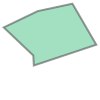

In [4]:
from collections import defaultdict
cdict = defaultdict(str)
vol_es, es_acc, upper, lower = ({} for i in range(4))
vol, es = ('', '')
latest_lat, latest_long, current_lat = (0.0, 0.0, 0.0)
boundary_required = False

for tag in list_tables[5].find_all('span'):
    if tag.has_attr('id'):
        if 'NOM_USUEL' in tag['id']:
            acc = tag.text
        elif 'AIRSPACE.TXT_NAME' in tag['id']:
            es = tag.text
            es_acc[es] = acc
            vol = es
            vol_es[vol] = es
        elif 'DIST_VER_UPPER' in tag['id']:
            upper[vol] = tag.text
        elif 'DIST_VER_LOWER' in tag['id']:
            lower[vol] = tag.text
        elif 'GEO_LAT' in tag['id']:
            if tag.text[0].isdigit():
                lat = lat_conv(tag.text)
                if boundary_required:
                    current_lat = lat
                else:
                    latest_lat = lat
        elif 'GEO_LONG' in tag['id']:
            if tag.text[0].isdigit():
                lon = lon_conv(tag.text)
                if boundary_required:
                    ch = get_points_between(Point(latest_long, latest_lat), Point(lon, current_lat))
                    for pt in ch:
                        cdict[vol] += str(pt.y) + ";" + str(pt.x) + ","
                    cdict[vol] += str(current_lat) + ";" + str(lon) + ","
                    boundary_required = False
                else:
                    latest_long = lon
                    cdict[vol] += str(latest_lat) + ";" + str(lon) + ","
        elif 'GEO_BORDER.NOM' in tag['id']:
            boundary_required = True
        elif 'AIRSPACE_BORDER.NOM_PARTIE' in tag['id']:
            if (len(tag.text) == 1) and (tag.text[0].isdigit()):
                vol_es.pop(vol)
                vol += " " + tag.text[0]
                vol_es[vol] = es
    else: # second column
        if (len(tag.text) == 1) and (tag.text[0].isdigit()):
                vol_es.pop(vol)
                vol += " " + tag.text[0]
                vol_es[vol] = es

fdict = defaultdict(list)
for key, value in cdict.items():
    for couple in value.split(","):
        if len(couple) > 0:
            fdict[key].append((float(couple.split(";")[1]), float(couple.split(";")[0])))
city_acc_map = {'BORDEAUX':'LFBB', 'BREST':'LFRR', 'MARSEILLE':'LFMM', 'PARIS':'LFFF', 'REIMS':'LFEE'}
es_acc = {key: city_acc_map[value] for key,value in es_acc.items()}
fdict = {key: Polygon(value) for key, value in fdict.items()}
fdict['P1 1']

##### Building the GeoDataFrame

In [5]:
import pandas as pd
df_v = pd.DataFrame({'volume': [*fdict]}, dtype=str)
df_v['elementary_sector'] = df_v['volume'].map(vol_es)
df_v['acc'] = df_v['elementary_sector'].map(es_acc)
df_v['level_min'] = df_v['volume'].map(lower)
df_v['level_max'] = df_v['volume'].map(upper)
df_v['geometry'] = df_v['volume'].map(fdict)
f = lambda x: 0 if x == 'SFC' else 999 if x == 'UNL' else int(x[3:]) # to be modified with real SFC/UNL values
df_v[['level_min','level_max']] = df_v[['level_min','level_max']].applymap(f)
gdf_es = gpd.GeoDataFrame(df_v, geometry='geometry')
gdf_es.to_file('volumes.geojson', driver='GeoJSON')

##### Get the composition of collapse sectors (five first tables)

In [6]:
def table_to_df(table, name):
    vol_dict = defaultdict(list)
    es_dict = defaultdict(set)
    cs = ""
    for tag in table.find_all('span'):
        if tag.has_attr('class'):
            cs = tag.text
        else:
            vol_dict[cs].append(tag.text)
            es_dict[cs].add(vol_es[tag.text])
    es_dict = {key: list(value) for key, value in es_dict.items()}
    cs = [*vol_dict]
    df = pd.DataFrame({'control_sector': cs, 'acc':[name for i in range(len(cs))]})
    df['volumes'] = df['control_sector'].map(vol_dict)
    df['elementary_sectors'] = df['control_sector'].map(es_dict)
    return df

##### Building the control sectors dataframe

In [7]:
list_acc = ['LFBB', 'LFRR', 'LFMM', 'LFFF', 'LFEE']
lfbb, lfrr, lfmm, lfff, lfee = (table_to_df(list_tables[i], list_acc[i]) for i in range(5))
acc = pd.concat([lfbb, lfrr, lfmm, lfff, lfee])
acc.sample(3)

,acc,control_sector,volumes,elementary_sectors
68,LFRR,VKWS,"[VS, KS, WS 1, WS 2, WS 3, WS 4, WS 5]","[WS, VS, KS]"
87,LFMM,SBAM,"[ST 1, ST 2, BT 1, BT 2, AJ 1, AJ 2, MN 1, MN 2]","[AJ, BT, MN, ST]"
82,LFMM,RAW,"[MO, ML 1, ML 2, LE1 1, LE1 2, LE2, LO 1, LO 2...","[F4, LE2, DL, M1, M2, ML, M3, LE1, W1, LO, F1,..."


In [8]:
acc.to_csv('sectors.csv', index=False)